### Spatial features of measles transmission in England and Wales during the pre-vaccine era
In this notebook, we will move away from theoretical results and aim to model a famous observational dataset in disease transmission - records of measles cases in England and Wales during the pre-vaccine era.  This is a dataset that has been modeled in a number of famous publications and used to demonstrate phenomena like switching from annual to biennial epidemics in the face of demographic changes, traveling wave-like behavior from cities to smaller population centers around them, and disease extinction in sub-CCS populations followed by reimportation from elsewhere.  Here, we will aim to reproduce two of these results in a single spatial model - the demonstration of traveling waves of infection from [Grenfell BT, Bjørnstad ON, Kappey J. _Travelling waves and spatial hierarchies in measles epidemics._ Nature. 2001 Dec 13;414(6865):716-23](https://www.nature.com/articles/414716a), and the interplay between exinction and reimportation vs. population size from [Conlan AJ et al. _Resolving the impact of waiting time distributions on the persistence of measles._ J R Soc Interface. 2010 Apr 6;7(45):623-40](https://pmc.ncbi.nlm.nih.gov/articles/PMC2842776/).

This notebook will also demonstrate construction of a spatial population scenario representing real populations, rather than the grids used up until now.  This dataset also covers a period of time with important dynamics in birth and deaths rates, that produce their own interesting impacts on measles dynamics, but for now we will model constant birth and death rates as the phenomena we seek to reproduce are driven more by spatial connections between populations.  In the future, we will return to this scenario and also use this to demonstrate for users how to set up spatiotemporally varying demographics from existing datasets.

In [1]:
import numpy as np
import pandas as pd
import numba as nb
import os
import sys
from laser.core.propertyset import PropertySet
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser.generic import SEIR
from laser.generic import Model
from laser.generic.utils import ValuesMap
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator
from laser.core.migration import gravity
from laser.core.migration import row_normalizer

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import pywt


import laser.core
import laser.generic

data_dir = os.path.join('..', '..', '..', "data")
sys.path.append(data_dir)

from EnglandWalesmeasles import data as engwal
distances = np.load(os.path.join("..", "..", "..", "data", "EnglandWalesdistances.npy"))

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


np.__version__='2.2.6'
laser.core.__version__='0.9.1'
laser.generic.__version__='0.0.0'


In [2]:
class Importation:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 30, count: int = 3, end_tick: int = 10*365):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count
        self.end_tick = end_tick if end_tick is not None else model.params.nticks

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0 and tick < self.end_tick:
            i_susceptible = np.nonzero(self.model.people.state == SEIR.State.SUSCEPTIBLE.value)[0]
            if len(i_susceptible) > 0:
                count = min(self.count, len(i_susceptible))
                i_infect = np.random.choice(i_susceptible, size=count, replace=False)
                self.model.people.state[i_infect] = SEIR.State.INFECTIOUS.value
                samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                samples = np.round(samples)
                samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                self.model.people.itimer[i_infect] = samples
                inf_by_node = np.bincount(self.model.people.nodeid[i_infect], minlength=len(self.model.nodes)).astype(self.model.nodes.S.dtype)
                self.model.nodes.S[tick + 1] -= inf_by_node
                self.model.nodes.I[tick + 1] += inf_by_node
                self.model.nodes.imports[tick] = inf_by_node
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return

class SeasonalTransmission(SEIR.Transmission):
        
    def step(self, tick: int) -> None:
        ft = self.model.nodes.forces[tick]

        N = self.model.nodes.S[tick] + self.model.nodes.E[tick] + (I := self.model.nodes.I[tick])  # noqa: E741
        # Might have R
        if hasattr(self.model.nodes, "R"):
            N += self.model.nodes.R[tick]

        ft[:] = self.model.params.beta * I / N * self.model.params.beta_season[tick % 365]
        transfer = ft[:, None] * self.model.network
        ft += transfer.sum(axis=0)
        ft -= transfer.sum(axis=1)
        ft = -np.expm1(-ft)  # Convert to probability of infection

        newly_infected_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.int32)
        self.nb_transmission_step(
            self.model.people.state,
            self.model.people.nodeid,
            ft,
            newly_infected_by_node,
            self.model.people.etimer,
            self.expdurdist,
            self.expdurmin,
            tick,
        )
        newly_infected_by_node = newly_infected_by_node.sum(axis=0).astype(self.model.nodes.S.dtype)  # Sum over threads

        # state(t+1) = state(t) + ∆state(t)
        self.model.nodes.S[tick + 1] -= newly_infected_by_node
        self.model.nodes.E[tick + 1] += newly_infected_by_node
        # Record today's ∆
        self.model.nodes.newly_infected[tick] = newly_infected_by_node

        return

In [3]:
# See ../../../data/readme.md for a description of the England and Wales measles data contained there.  
# We provide pre-computed pairwise distances between the population centers in EnglandWalesdistances.npy.
# Here, we compute a population-wide average crude birth rate (CBR) for England and Wales from the data.

average_pop = np.array([np.mean(place.population) for place in engwal.places.values()])
average_birthrate = np.array([np.mean(place.births/place.population) for place in engwal.places.values()])
average_cbr = 1000*np.sum(average_pop*average_birthrate)/np.sum(average_pop)
birthrates = np.array([place.births/place.population *1000 for place in engwal.places.values()])

In [4]:
# Define the geodataframe
cells = []
for placename, place in engwal.places.items():
    lat, long = place.latitude, place.longitude
    nodeid = engwal.placenames.index(placename)
    name = placename
    # As long as we are here, record the proportion of weeks with zero cases.  
    # Wavelet analysis is more complex and we will come back to that later.
    prop_zero = np.mean(np.array(place.cases) == 0)

    cells.append({"nodeid": nodeid, "name": name, "population": place.population[0], "geometry": Point(long, lat), "prop_zero": prop_zero})

scenario = gpd.GeoDataFrame(cells, columns=["nodeid", "name", "population", "geometry", "prop_zero"], crs="EPSG:4326")

In [ ]:
run_sims = False
start_from_last = False


# NOTE

**The 150 sims below - ~30M agents for 20 years - take some hours to run even on modern hardware. If you want to re-run the sims, consider running this part of the notebook overnight.**

### Calibration
In order to reproduce the fadeout/reimportation phenomenon and the travelling wave dynamics observed in the measles dataset, we will have to undergo a calibration exercise - the model will not faithfully reproduce all of the details of the data for any set of input parameters.  We are faced with a fairly large parameter space to deal with - exposed/infectious periods, infectivity, amplitude and shape of seasonal forcing in infectivity, and the migration network between populations.  For the purposes of this demonstration, we will leverage existing knowledge of the biology of measles and past analyses of this data to restrict our priors and get to a place where we should be able to produce reasonable results with order 100 simulations - manageable for a powerful laptop in order hours, or in a matter of minutes on a HPC cluster.

We will choose distributions that put the exposed and infectious periods at 10 and 8 days long, respectively, with a std. deviation of a couple of days each.  

The work in Bjørnstad, O.N., Finkenstädt, B.F. and Grenfell, B.T. (2002), _Dynamics of Measles Epidemics: Estimating Scaling of Transmission Rates Using a Time Series SIR Model_. Ecological Monographs, 72: 169-184 explores inferring the transmission rates.  In the discussion section, they find that under the assumption of homogenous mixing within spatial units (as in our model), $R_0$ is on average equal to approximately 30 and varies throughout the year, with a minimum of around 19 and a maximum around 40.  So in our calibration exercise, we will take values in this vinicity, and use the seasonal forcing profile estimated in that work.

Other sources and some intuition can help constrain the search space for the migration model parameters.  To keep things simple, we will use a gravity model with 4 parameters

$$
M_{i,j} = k \frac{p_i^a p_j^b}{d^c}
$$

Our work with the 2-patch SIR system revealed that there is roughly 2 orders of magnitude in overall coupling in which "interesting" stuff happens (i.e., the system is not totally decoupled and also not fully synchronized), between about 0.001 and 0.1.  We can extrapolate from this and explore values of $k$ such that the average node is exporting a fraction of its infectivity in this range.   Prior study of the time between fadeout and reimportation has found that the importation rate into a node seems to scale like the square root of the node population (see Keeling & Rohani, ref appropriately here), so we will explore values of $b$ in the vicinity of 0.5.  As to $a$, we'll assume that there's no "self-gravity" here and set this to zero - that is, a person's propensity to travel to other places is independent of the population of their home and determined entirely by the distance to and population of potential destinations.  Finally, w/r/t $c$, we'll assume that the difficulty of traveling somewhere is at least linear in distance and explore values from 1 to 2.

In [11]:

output_file = os.path.join("outputs", "EW_outputs.npy")
params_file = os.path.join("outputs", "EW_parameter_samples.csv")
nsims = 150
nticks = 40*365
npatches = len(scenario)
if run_sims:
    istart = 0
    if start_from_last and (os.path.exists(output_file) 
                            and os.path.exists(params_file)):

        print("Resuming from last saved simulation...")

        outputs =np.load(output_file)
        while istart < outputs.shape[0] and np.any(outputs[istart]):
            istart += 1
        params_df = pd.read_csv(params_file)
        beta_samples = params_df["beta"].values
        amplitude_samples = params_df["amplitude"].values
        k_samples = params_df["k"].values
        b_samples = params_df["b"].values
        c_samples = params_df["c"].values

    else:

        print("Starting new set of simulations...")

        beta_samples = np.random.uniform(3, 4.5, nsims) #Ro from 24 to 36
        amplitude_samples = np.random.uniform(0.5, 1.5, nsims) #1 will be exactly the seasonal forcing profile from reference above
        k_samples = 10 ** np.random.uniform(-3.5, -1, nsims)
        #a_samples = np.random.uniform(-0.5, 0.5, nsims)
        b_samples = np.random.uniform(0.25, 1.0, nsims)
        c_samples = np.random.uniform(1, 2, nsims)
        params_df = pd.DataFrame({
            "beta": beta_samples,
            "amplitude": amplitude_samples,
            "k": k_samples,
            "b": b_samples,
            "c": c_samples
        })
        os.makedirs("outputs", exist_ok=True)
        params_df.to_csv(params_file, index=False)
        outputs = np.zeros((nsims, (nticks+1) // 7, npatches), dtype=np.uint32)
    
    log_betas = np.array([0.155, 0.571, 0.46, 0.34, 0.30, 0.34, 0.24, 0.15, 0.31, 0.40, 0.323, 0.238, 0.202, 0.203, 0.074,
        -0.095, -0.218, -0.031, 0.433, 0.531, 0.479, 0.397, 0.444, 0.411, 0.291, 0.509])
    beta_season = np.repeat(log_betas, np.floor(365 / len(log_betas)).astype(int))
    beta_season = np.append(beta_season, beta_season[-1])
    beta_season = np.exp( (beta_season - np.mean(beta_season)) )

    for i in range(istart, nsims):
        print(f"Running simulation {i+1} of {nsims}...")
        parameters = PropertySet(
            {"seed": 4, "nticks": nticks,
            "exp_shape": 40, "exp_scale": 0.25,
            "verbose": True, "beta": beta_samples[i], "inf_mean": 8, "inf_sigma": 2, "cbr": average_cbr,
            "beta_season": beta_season**amplitude_samples[i],
            "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 10*365,
            "gravity_k": k_samples[i], "gravity_b": b_samples[i], "gravity_c": c_samples[i],
            "skip_capacity": False, "capacity_safety_factor": 3.0}
        )

        scenario["E"] = 0
        scenario["I"] = 3
        scenario["R"] = np.round(0.95 * scenario.population).astype(np.uint32)
        scenario["S"] = scenario.population - scenario["E"] - scenario["I"] - scenario["R"]

        expdist = dists.gamma(shape=parameters.exp_shape, scale=parameters.exp_scale)
        infdist = dists.normal(loc=parameters.inf_mean, scale=parameters.inf_sigma)

        birthrate_map = ValuesMap.from_scalar(parameters.cbr, nticks=parameters.nticks, nnodes=len(scenario))
        rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) # approximate annual to daily
        stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
        pyramid = AliasedDistribution(stable_age_dist)
        survival = KaplanMeierEstimator(stable_age_dist.cumsum())
        model = Model(scenario, parameters, birthrates=birthrate_map.values)

        model.components = [
            SEIR.Susceptible(model),
            SEIR.Exposed(model, expdist, infdist),
            SEIR.Infectious(model, infdist),
            SEIR.Recovered(model),
            Importation(model, infdist),
            SeasonalTransmission(model, infdist),
            BirthsByCBR(model, birthrates=birthrate_map.values, pyramid=pyramid),
            MortalityByEstimator(model, estimator=survival),
        ]

        model.network = gravity(np.array(scenario.population), distances, 1, 0, model.params.gravity_b, model.params.gravity_c)
        # The scale of the parameter k is actually unit-ful, and depends on the values of b and c.  
        # To make k more interpretable, and avoid having to sample large swaths of useless parameter space,
        # we rescale the network here so that the average export fraction is 1, then multiply by k.
        average_export_frac = np.mean(model.network.sum(axis=1))
        model.network = model.network / average_export_frac * model.params.gravity_k 
        model.network = row_normalizer(model.network, 0.2) #Don't let any individual node send more than 20% of its infectivity elsewhere.

        model.run(f"Sim {i+1}/{nsims}")
        incidence = model.nodes.newly_infected
        num_weeks = incidence.shape[0] // 7
        weekly_incidence = incidence[:num_weeks*7, :].reshape(num_weeks, 7, incidence.shape[1]).sum(axis=1)        
        outputs[i, :, :] = weekly_incidence
        np.save(output_file, outputs)

Starting new set of simulations...
Running simulation 1 of 150...


Sim 1/150: 100%|██████████| 14600/14600 [03:11<00:00, 76.06it/s]


Running simulation 2 of 150...


Sim 2/150: 100%|██████████| 14600/14600 [02:48<00:00, 86.58it/s]


Running simulation 3 of 150...


Sim 3/150: 100%|██████████| 14600/14600 [03:08<00:00, 77.36it/s]


Running simulation 4 of 150...


Sim 4/150: 100%|██████████| 14600/14600 [03:06<00:00, 78.46it/s]


Running simulation 5 of 150...


Sim 5/150: 100%|██████████| 14600/14600 [02:42<00:00, 89.79it/s] 


Running simulation 6 of 150...


Sim 6/150: 100%|██████████| 14600/14600 [02:49<00:00, 86.24it/s]


Running simulation 7 of 150...


Sim 7/150: 100%|██████████| 14600/14600 [02:53<00:00, 83.96it/s]


Running simulation 8 of 150...


Sim 8/150: 100%|██████████| 14600/14600 [02:38<00:00, 92.11it/s]


Running simulation 9 of 150...


Sim 9/150: 100%|██████████| 14600/14600 [02:45<00:00, 88.07it/s]


Running simulation 10 of 150...


Sim 10/150: 100%|██████████| 14600/14600 [02:43<00:00, 89.46it/s]


Running simulation 11 of 150...


Sim 11/150: 100%|██████████| 14600/14600 [02:58<00:00, 81.72it/s]


Running simulation 12 of 150...


Sim 12/150: 100%|██████████| 14600/14600 [03:03<00:00, 79.36it/s]


Running simulation 13 of 150...


Sim 13/150: 100%|██████████| 14600/14600 [02:52<00:00, 84.75it/s]


Running simulation 14 of 150...


Sim 14/150: 100%|██████████| 14600/14600 [02:54<00:00, 83.69it/s]


Running simulation 15 of 150...


Sim 15/150: 100%|██████████| 14600/14600 [02:36<00:00, 93.18it/s]


Running simulation 16 of 150...


Sim 16/150: 100%|██████████| 14600/14600 [03:20<00:00, 72.85it/s]


Running simulation 17 of 150...


Sim 17/150: 100%|██████████| 14600/14600 [03:09<00:00, 76.89it/s]


Running simulation 18 of 150...


Sim 18/150: 100%|██████████| 14600/14600 [03:14<00:00, 75.25it/s]


Running simulation 19 of 150...


Sim 19/150: 100%|██████████| 14600/14600 [03:00<00:00, 80.97it/s]


Running simulation 20 of 150...


Sim 20/150: 100%|██████████| 14600/14600 [03:00<00:00, 80.87it/s]


Running simulation 21 of 150...


Sim 21/150: 100%|██████████| 14600/14600 [02:53<00:00, 84.30it/s]


Running simulation 22 of 150...


Sim 22/150: 100%|██████████| 14600/14600 [03:06<00:00, 78.47it/s]


Running simulation 23 of 150...


Sim 23/150: 100%|██████████| 14600/14600 [02:55<00:00, 83.30it/s]


Running simulation 24 of 150...


Sim 24/150: 100%|██████████| 14600/14600 [02:46<00:00, 87.89it/s]


Running simulation 25 of 150...


Sim 25/150: 100%|██████████| 14600/14600 [03:04<00:00, 78.99it/s]


Running simulation 26 of 150...


Sim 26/150: 100%|██████████| 14600/14600 [02:48<00:00, 86.85it/s]


Running simulation 27 of 150...


Sim 27/150: 100%|██████████| 14600/14600 [03:15<00:00, 74.60it/s]


Running simulation 28 of 150...


Sim 28/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.24it/s]


Running simulation 29 of 150...


Sim 29/150: 100%|██████████| 14600/14600 [02:47<00:00, 87.13it/s]


Running simulation 30 of 150...


Sim 30/150: 100%|██████████| 14600/14600 [02:48<00:00, 86.80it/s]


Running simulation 31 of 150...


Sim 31/150: 100%|██████████| 14600/14600 [02:49<00:00, 86.00it/s]


Running simulation 32 of 150...


Sim 32/150: 100%|██████████| 14600/14600 [03:07<00:00, 77.85it/s]


Running simulation 33 of 150...


Sim 33/150: 100%|██████████| 14600/14600 [02:44<00:00, 88.96it/s]


Running simulation 34 of 150...


Sim 34/150: 100%|██████████| 14600/14600 [02:28<00:00, 98.57it/s] 


Running simulation 35 of 150...


Sim 35/150: 100%|██████████| 14600/14600 [03:21<00:00, 72.45it/s]


Running simulation 36 of 150...


Sim 36/150: 100%|██████████| 14600/14600 [02:58<00:00, 81.92it/s]


Running simulation 37 of 150...


Sim 37/150: 100%|██████████| 14600/14600 [03:13<00:00, 75.35it/s]


Running simulation 38 of 150...


Sim 38/150: 100%|██████████| 14600/14600 [02:45<00:00, 88.38it/s]


Running simulation 39 of 150...


Sim 39/150: 100%|██████████| 14600/14600 [02:44<00:00, 88.51it/s]


Running simulation 40 of 150...


Sim 40/150: 100%|██████████| 14600/14600 [02:46<00:00, 87.45it/s]


Running simulation 41 of 150...


Sim 41/150: 100%|██████████| 14600/14600 [02:42<00:00, 90.09it/s]


Running simulation 42 of 150...


Sim 42/150: 100%|██████████| 14600/14600 [02:32<00:00, 95.56it/s] 


Running simulation 43 of 150...


Sim 43/150: 100%|██████████| 14600/14600 [02:38<00:00, 92.28it/s]


Running simulation 44 of 150...


Sim 44/150: 100%|██████████| 14600/14600 [03:08<00:00, 77.57it/s]


Running simulation 45 of 150...


Sim 45/150: 100%|██████████| 14600/14600 [02:49<00:00, 86.27it/s]


Running simulation 46 of 150...


Sim 46/150: 100%|██████████| 14600/14600 [02:53<00:00, 83.98it/s]


Running simulation 47 of 150...


Sim 47/150: 100%|██████████| 14600/14600 [02:38<00:00, 92.14it/s]


Running simulation 48 of 150...


Sim 48/150: 100%|██████████| 14600/14600 [02:57<00:00, 82.45it/s]


Running simulation 49 of 150...


Sim 49/150: 100%|██████████| 14600/14600 [02:51<00:00, 85.35it/s]


Running simulation 50 of 150...


Sim 50/150: 100%|██████████| 14600/14600 [03:07<00:00, 77.70it/s]


Running simulation 51 of 150...


Sim 51/150: 100%|██████████| 14600/14600 [02:38<00:00, 92.11it/s]


Running simulation 52 of 150...


Sim 52/150: 100%|██████████| 14600/14600 [02:41<00:00, 90.17it/s]


Running simulation 53 of 150...


Sim 53/150: 100%|██████████| 14600/14600 [03:17<00:00, 73.80it/s]


Running simulation 54 of 150...


Sim 54/150: 100%|██████████| 14600/14600 [03:04<00:00, 79.15it/s]


Running simulation 55 of 150...


Sim 55/150: 100%|██████████| 14600/14600 [02:40<00:00, 90.80it/s]


Running simulation 56 of 150...


Sim 56/150: 100%|██████████| 14600/14600 [03:04<00:00, 79.21it/s]


Running simulation 57 of 150...


Sim 57/150: 100%|██████████| 14600/14600 [02:42<00:00, 90.03it/s]


Running simulation 58 of 150...


Sim 58/150: 100%|██████████| 14600/14600 [02:54<00:00, 83.64it/s]


Running simulation 59 of 150...


Sim 59/150: 100%|██████████| 14600/14600 [03:00<00:00, 80.96it/s]


Running simulation 60 of 150...


Sim 60/150: 100%|██████████| 14600/14600 [02:56<00:00, 82.63it/s]


Running simulation 61 of 150...


Sim 61/150: 100%|██████████| 14600/14600 [03:02<00:00, 80.15it/s]


Running simulation 62 of 150...


Sim 62/150: 100%|██████████| 14600/14600 [02:50<00:00, 85.70it/s]


Running simulation 63 of 150...


Sim 63/150: 100%|██████████| 14600/14600 [02:48<00:00, 86.88it/s]


Running simulation 64 of 150...


Sim 64/150: 100%|██████████| 14600/14600 [02:56<00:00, 82.89it/s]


Running simulation 65 of 150...


Sim 65/150: 100%|██████████| 14600/14600 [02:56<00:00, 82.53it/s]


Running simulation 66 of 150...


Sim 66/150: 100%|██████████| 14600/14600 [03:08<00:00, 77.32it/s]


Running simulation 67 of 150...


Sim 67/150: 100%|██████████| 14600/14600 [02:46<00:00, 87.63it/s]


Running simulation 68 of 150...


Sim 68/150: 100%|██████████| 14600/14600 [02:47<00:00, 87.35it/s]


Running simulation 69 of 150...


Sim 69/150: 100%|██████████| 14600/14600 [02:49<00:00, 85.95it/s]


Running simulation 70 of 150...


Sim 70/150: 100%|██████████| 14600/14600 [03:11<00:00, 76.30it/s]


Running simulation 71 of 150...


Sim 71/150: 100%|██████████| 14600/14600 [02:41<00:00, 90.28it/s]


Running simulation 72 of 150...


Sim 72/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.34it/s]


Running simulation 73 of 150...


Sim 73/150: 100%|██████████| 14600/14600 [02:47<00:00, 87.20it/s]


Running simulation 74 of 150...


Sim 74/150: 100%|██████████| 14600/14600 [02:50<00:00, 85.57it/s]


Running simulation 75 of 150...


Sim 75/150: 100%|██████████| 14600/14600 [03:16<00:00, 74.47it/s]


Running simulation 76 of 150...


Sim 76/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.30it/s]


Running simulation 77 of 150...


Sim 77/150: 100%|██████████| 14600/14600 [03:09<00:00, 76.93it/s]


Running simulation 78 of 150...


Sim 78/150: 100%|██████████| 14600/14600 [03:02<00:00, 79.81it/s]


Running simulation 79 of 150...


Sim 79/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.33it/s]


Running simulation 80 of 150...


Sim 80/150: 100%|██████████| 14600/14600 [03:13<00:00, 75.57it/s]


Running simulation 81 of 150...


Sim 81/150: 100%|██████████| 14600/14600 [03:08<00:00, 77.42it/s]


Running simulation 82 of 150...


Sim 82/150: 100%|██████████| 14600/14600 [02:48<00:00, 86.84it/s]


Running simulation 83 of 150...


Sim 83/150: 100%|██████████| 14600/14600 [02:38<00:00, 92.35it/s]


Running simulation 84 of 150...


Sim 84/150: 100%|██████████| 14600/14600 [03:20<00:00, 72.68it/s]


Running simulation 85 of 150...


Sim 85/150: 100%|██████████| 14600/14600 [03:05<00:00, 78.68it/s]


Running simulation 86 of 150...


Sim 86/150: 100%|██████████| 14600/14600 [02:40<00:00, 90.85it/s]


Running simulation 87 of 150...


Sim 87/150: 100%|██████████| 14600/14600 [03:15<00:00, 74.61it/s]


Running simulation 88 of 150...


Sim 88/150: 100%|██████████| 14600/14600 [02:55<00:00, 83.32it/s]


Running simulation 89 of 150...


Sim 89/150: 100%|██████████| 14600/14600 [02:55<00:00, 82.99it/s]


Running simulation 90 of 150...


Sim 90/150: 100%|██████████| 14600/14600 [02:44<00:00, 88.76it/s]


Running simulation 91 of 150...


Sim 91/150: 100%|██████████| 14600/14600 [03:08<00:00, 77.49it/s]


Running simulation 92 of 150...


Sim 92/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.43it/s]


Running simulation 93 of 150...


Sim 93/150: 100%|██████████| 14600/14600 [03:04<00:00, 79.11it/s]


Running simulation 94 of 150...


Sim 94/150: 100%|██████████| 14600/14600 [02:56<00:00, 82.75it/s]


Running simulation 95 of 150...


Sim 95/150: 100%|██████████| 14600/14600 [03:03<00:00, 79.54it/s]


Running simulation 96 of 150...


Sim 96/150: 100%|██████████| 14600/14600 [02:50<00:00, 85.87it/s]


Running simulation 97 of 150...


Sim 97/150: 100%|██████████| 14600/14600 [02:54<00:00, 83.67it/s]


Running simulation 98 of 150...


Sim 98/150: 100%|██████████| 14600/14600 [02:51<00:00, 85.14it/s]


Running simulation 99 of 150...


Sim 99/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.26it/s]


Running simulation 100 of 150...


Sim 100/150: 100%|██████████| 14600/14600 [02:51<00:00, 85.00it/s]


Running simulation 101 of 150...


Sim 101/150: 100%|██████████| 14600/14600 [02:58<00:00, 81.85it/s]


Running simulation 102 of 150...


Sim 102/150: 100%|██████████| 14600/14600 [02:50<00:00, 85.56it/s]


Running simulation 103 of 150...


Sim 103/150: 100%|██████████| 14600/14600 [03:04<00:00, 79.16it/s]


Running simulation 104 of 150...


Sim 104/150: 100%|██████████| 14600/14600 [02:37<00:00, 92.69it/s]


Running simulation 105 of 150...


Sim 105/150: 100%|██████████| 14600/14600 [02:55<00:00, 82.97it/s]


Running simulation 106 of 150...


Sim 106/150: 100%|██████████| 14600/14600 [02:41<00:00, 90.40it/s]


Running simulation 107 of 150...


Sim 107/150: 100%|██████████| 14600/14600 [02:50<00:00, 85.47it/s]


Running simulation 108 of 150...


Sim 108/150: 100%|██████████| 14600/14600 [02:35<00:00, 94.12it/s]


Running simulation 109 of 150...


Sim 109/150: 100%|██████████| 14600/14600 [02:37<00:00, 92.56it/s] 


Running simulation 110 of 150...


Sim 110/150: 100%|██████████| 14600/14600 [02:48<00:00, 86.81it/s]


Running simulation 111 of 150...


Sim 111/150: 100%|██████████| 14600/14600 [02:51<00:00, 85.30it/s]


Running simulation 112 of 150...


Sim 112/150: 100%|██████████| 14600/14600 [03:13<00:00, 75.29it/s]


Running simulation 113 of 150...


Sim 113/150: 100%|██████████| 14600/14600 [03:05<00:00, 78.88it/s]


Running simulation 114 of 150...


Sim 114/150: 100%|██████████| 14600/14600 [03:02<00:00, 80.04it/s]


Running simulation 115 of 150...


Sim 115/150: 100%|██████████| 14600/14600 [02:33<00:00, 94.83it/s] 


Running simulation 116 of 150...


Sim 116/150: 100%|██████████| 14600/14600 [02:36<00:00, 93.08it/s]


Running simulation 117 of 150...


Sim 117/150: 100%|██████████| 14600/14600 [02:49<00:00, 86.23it/s]


Running simulation 118 of 150...


Sim 118/150: 100%|██████████| 14600/14600 [02:40<00:00, 90.71it/s]


Running simulation 119 of 150...


Sim 119/150: 100%|██████████| 14600/14600 [02:43<00:00, 89.39it/s]


Running simulation 120 of 150...


Sim 120/150: 100%|██████████| 14600/14600 [03:14<00:00, 75.01it/s]


Running simulation 121 of 150...


Sim 121/150: 100%|██████████| 14600/14600 [02:35<00:00, 94.10it/s]


Running simulation 122 of 150...


Sim 122/150: 100%|██████████| 14600/14600 [02:45<00:00, 87.98it/s]


Running simulation 123 of 150...


Sim 123/150: 100%|██████████| 14600/14600 [02:45<00:00, 88.35it/s]


Running simulation 124 of 150...


Sim 124/150: 100%|██████████| 14600/14600 [02:47<00:00, 87.36it/s]


Running simulation 125 of 150...


Sim 125/150: 100%|██████████| 14600/14600 [02:41<00:00, 90.42it/s]


Running simulation 126 of 150...


Sim 126/150: 100%|██████████| 14600/14600 [03:11<00:00, 76.25it/s]


Running simulation 127 of 150...


Sim 127/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.22it/s]


Running simulation 128 of 150...


Sim 128/150: 100%|██████████| 14600/14600 [02:51<00:00, 85.30it/s]


Running simulation 129 of 150...


Sim 129/150: 100%|██████████| 14600/14600 [02:39<00:00, 91.74it/s]


Running simulation 130 of 150...


Sim 130/150: 100%|██████████| 14600/14600 [03:10<00:00, 76.75it/s]


Running simulation 131 of 150...


Sim 131/150: 100%|██████████| 14600/14600 [02:52<00:00, 84.72it/s]


Running simulation 132 of 150...


Sim 132/150: 100%|██████████| 14600/14600 [03:08<00:00, 77.53it/s]


Running simulation 133 of 150...


Sim 133/150: 100%|██████████| 14600/14600 [02:52<00:00, 84.46it/s]


Running simulation 134 of 150...


Sim 134/150: 100%|██████████| 14600/14600 [02:42<00:00, 89.93it/s]


Running simulation 135 of 150...


Sim 135/150: 100%|██████████| 14600/14600 [02:57<00:00, 82.30it/s]


Running simulation 136 of 150...


Sim 136/150: 100%|██████████| 14600/14600 [03:09<00:00, 77.18it/s]


Running simulation 137 of 150...


Sim 137/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.35it/s]


Running simulation 138 of 150...


Sim 138/150: 100%|██████████| 14600/14600 [03:04<00:00, 79.13it/s]


Running simulation 139 of 150...


Sim 139/150: 100%|██████████| 14600/14600 [02:53<00:00, 84.31it/s]


Running simulation 140 of 150...


Sim 140/150: 100%|██████████| 14600/14600 [02:53<00:00, 84.28it/s]


Running simulation 141 of 150...


Sim 141/150: 100%|██████████| 14600/14600 [02:55<00:00, 83.07it/s]


Running simulation 142 of 150...


Sim 142/150: 100%|██████████| 14600/14600 [02:50<00:00, 85.55it/s]


Running simulation 143 of 150...


Sim 143/150: 100%|██████████| 14600/14600 [02:43<00:00, 89.11it/s]


Running simulation 144 of 150...


Sim 144/150: 100%|██████████| 14600/14600 [03:17<00:00, 74.01it/s]


Running simulation 145 of 150...


Sim 145/150: 100%|██████████| 14600/14600 [02:47<00:00, 87.40it/s]


Running simulation 146 of 150...


Sim 146/150: 100%|██████████| 14600/14600 [03:15<00:00, 74.58it/s]


Running simulation 147 of 150...


Sim 147/150: 100%|██████████| 14600/14600 [03:01<00:00, 80.28it/s]


Running simulation 148 of 150...


Sim 148/150: 100%|██████████| 14600/14600 [02:51<00:00, 85.28it/s]


Running simulation 149 of 150...


Sim 149/150: 100%|██████████| 14600/14600 [02:42<00:00, 89.66it/s]


Running simulation 150 of 150...


Sim 150/150: 100%|██████████| 14600/14600 [02:47<00:00, 86.93it/s]


In [12]:
weekly_incidence = np.load('outputs/EW_outputs.npy')
params_df = pd.read_csv('outputs/EW_parameter_samples.csv')
results_df = params_df.copy()

prop_zero = np.mean(weekly_incidence[:, 1040:, :]==0, axis=1)
prop_low = np.mean(weekly_incidence[:, 1040:, :]<=2, axis=1)

results_df["prop_zero"] = list(prop_zero)
results_df["prop_low"] = list(prop_low)

In [13]:
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

# 1. Define fitting functions for mean and variance
def logistic(x, x0, k):
    # Logistic function bounded between 0 and 1, transitions from 1 to 0 as x increases
    return 1 / (1 + np.exp(k * (x - x0)))

def fit_mean_var(x, y):
    # Fit a logistic to the mean
    # Initial guess: midpoint at median(x), width=1
    p0 = [np.median(x), 1.0]
    bounds = ([-np.inf, 0.01], [np.inf, 10.0])
    popt_mean, _ = curve_fit(logistic, x, y, p0=p0, bounds=bounds, maxfev=10000)
    return popt_mean

# 3. Define similarity metric (sum of squared differences of mean and variance fits)
def similarity_metric(mean_data, mean_sim):
    # Evaluate both curves on a common grid
    x_grid = np.linspace(2.5, 6.5, 200)
    data_curve = logistic(x_grid, *mean_data)
    sim_curve = logistic(x_grid, *mean_sim)
    # Similarity: sum of squared differences between the curves
    mean_diff = np.sum((sim_curve - data_curve) ** 2)
    return mean_diff

similarity = []

for i in results_df.index:
    # Plot observed and simulated data
    logpop_obs = np.log10(scenario.population)
    prop_zero_obs = scenario.prop_zero
    logpop_sim = np.log10(scenario.population)
    prop_zero_sim = results_df.loc[i]['prop_zero']

    # Fit to observed
    popt_obs = fit_mean_var(logpop_obs, prop_zero_obs)
    popt_sim = fit_mean_var(logpop_sim, prop_zero_sim)
    # Similarity metric
    similarity.append(similarity_metric(popt_obs, popt_sim))
results_df["similarity_CCS"] = similarity




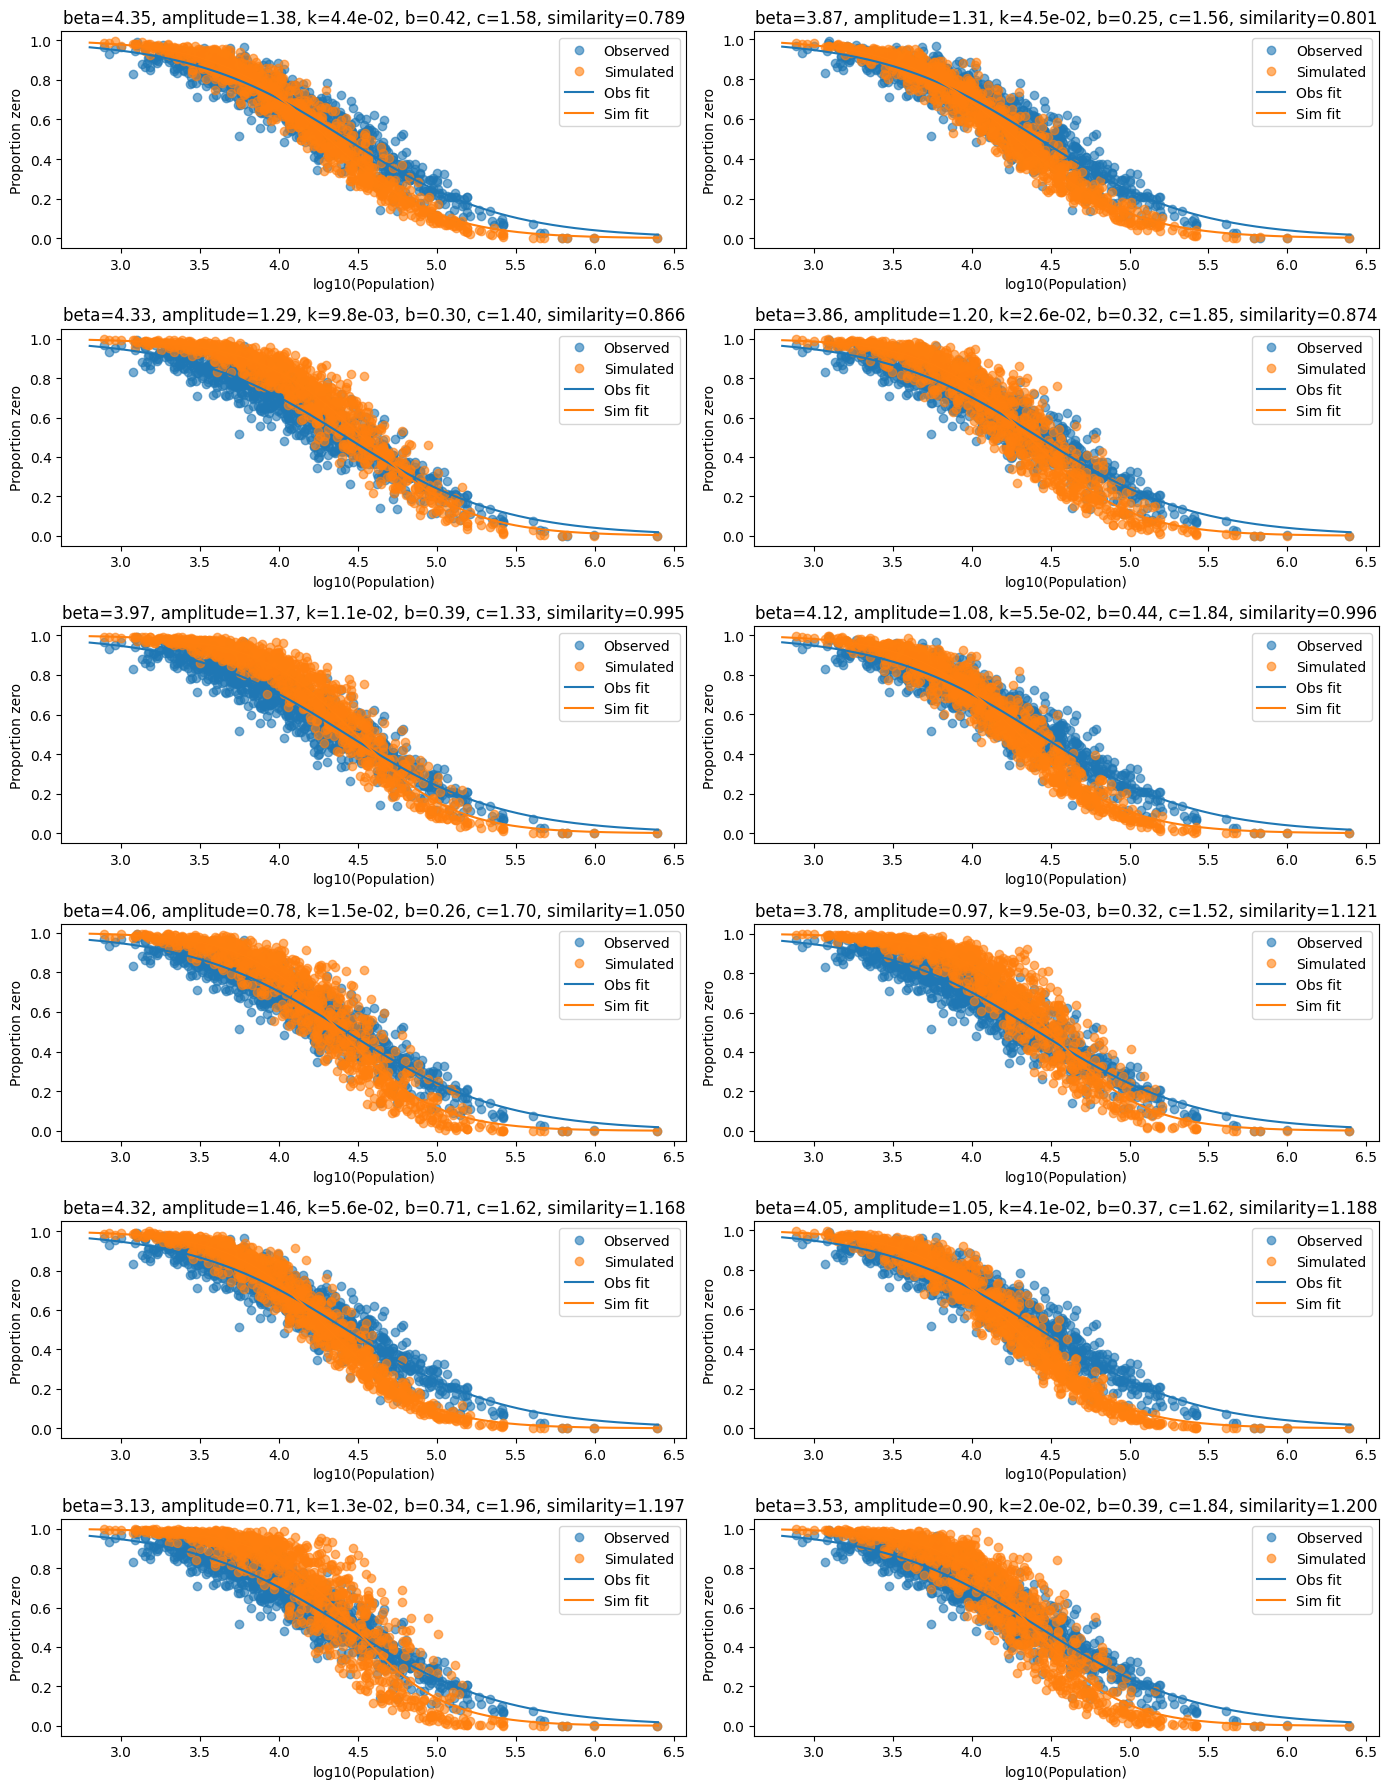

In [14]:
fig, axes = plt.subplots(6, 2, figsize=(14, 18))
axes = axes.flatten()

ranked_params = results_df.sort_values('similarity_CCS', ascending=True).reset_index(drop=True)
ranked_params[0:20]

for idx in range(12):
    # Get the parameter set with the idx-th lowest similarity
    beta_best, amp_best, k_best, b_best, c_best = ranked_params.loc[idx, ['beta', 'amplitude', 'k', 'b', 'c']]
    sim_score = ranked_params.loc[idx, 'similarity_CCS']
    prop_zero_sim = ranked_params.loc[idx, 'prop_zero']

    # Fit logistic to simulation
    popt_sim = fit_mean_var(np.log10(scenario.population), prop_zero_sim)
    # Fit logistic to observed (reuse from above)
    popt_obs = fit_mean_var(np.log10(scenario.population), scenario.prop_zero)

    xfit = np.linspace(2.8, 6.4, 200)
    axes[idx].plot(np.log10(scenario.population), scenario.prop_zero, 'o', label='Observed', alpha=0.6)
    axes[idx].plot(np.log10(scenario.population), prop_zero_sim, 'o', label='Simulated', alpha=0.6)
    axes[idx].plot(xfit, logistic(xfit, *popt_obs), '-', label='Obs fit', color='C0')
    axes[idx].plot(xfit, logistic(xfit, *popt_sim), '-', label='Sim fit', color='C1')
    axes[idx].set_title(f"beta={beta_best:.2f}, amplitude={amp_best:.2f}, k={k_best:.1e}, b={b_best:.2f}, c={c_best:.2f}, similarity={sim_score:.3f}")
    axes[idx].set_xlabel("log10(Population)")
    axes[idx].set_ylabel("Proportion zero")
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [15]:
def pad_data(x):
    """
    Pad data to the next power of 2
    """
    nx = len(x) # number of samples
    nx2 = (2**np.ceil(np.log(nx)/np.log(2))).astype(int) # next power of 2
    x2 = np.zeros(nx2, dtype=x.dtype) # pad to next power of 2
    offset = (nx2-nx)//2 # offset
    x2[offset:(offset+nx)] = x # copy
    return x2

def log_transform(x, debug=1):
    """
    Log transform for case data
    """ 
    # add one and take log
    x = np.log(x+1)
    # set mean=0 and std=1
    m = np.mean(x)
    s = np.std(x)
    x = (x - m)/s
    return x


def calc_Ws(cases):
    # transform case data
    log_cases = pad_data(log_transform(cases))

    # setup and execute wavelet transform
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#morlet-wavelet
    wavelet = pywt.ContinuousWavelet('cmor2-1')

    dt = 1 # 2 weeks
    widths = np.logspace(np.log10(1), np.log10(7*52), int(7*52))
    [cwt, frequencies] = pywt.cwt(log_cases, widths, wavelet, dt)

    # Number of time steps in padded time series
    nt = len(cases)
    # trim matrix
    offset = (cwt.shape[1] - nt) // 2
    cwt = cwt[:, offset:offset + nt]

    return cwt, frequencies


In [16]:
def wavelet_phase_diff(data, distances, ref_cwt):


    if isinstance(data, pd.DataFrame):
        x = np.zeros(len(data))
        y = np.zeros(len(data))
        y2 = np.zeros(len(data))
        for i, row in data.iterrows():
            if distances[i] > 30:
                continue
            cwt, frequencies = calc_Ws(row["cases"].flatten())
            diff = ref_cwt*np.conj(cwt)
            ind = np.where(np.logical_and(frequencies < 1/(1.5 * 52), frequencies > 1 / (3 * 52))) #Frequencies around 2 year periods.
            diff1 = diff[ind[0], :]
            x[i] = distances[i]
            y[i] = np.angle(np.mean(diff1))
            ind2 = np.where(np.logical_and(frequencies < 1/(0.75 * 52), frequencies > 1 / (1.25 * 52))) #Frequencies around 1 year periods
            diff2 = diff[ind2[0], :]
            y2[i] = np.angle(np.mean(diff2))
            
    elif isinstance(data, np.ndarray):
        # initialize output arrays
        x = np.zeros(data.shape[1])
        y = np.zeros(data.shape[1])
        y2 = np.zeros(data.shape[1])
        for i in range(data.shape[1]):
            if distances[i] > 30:
                continue
            cwt, frequencies = calc_Ws(data[:, i].flatten())
            diff = ref_cwt*np.conj(cwt)
            ind = np.where(np.logical_and(frequencies < 1/(1.5 * 52), frequencies > 1 / (3 * 52)))
            diff1 = diff[ind[0], :]
            x[i] = distances[i]
            y[i] = np.angle(np.mean(diff1))
            ind2 = np.where(np.logical_and(frequencies < 1/(0.75 * 52), frequencies > 1 / (1.25 * 52)))
            diff2 = diff[ind2[0], :]
            y2[i] = np.angle(np.mean(diff2))
    return x, y, y2

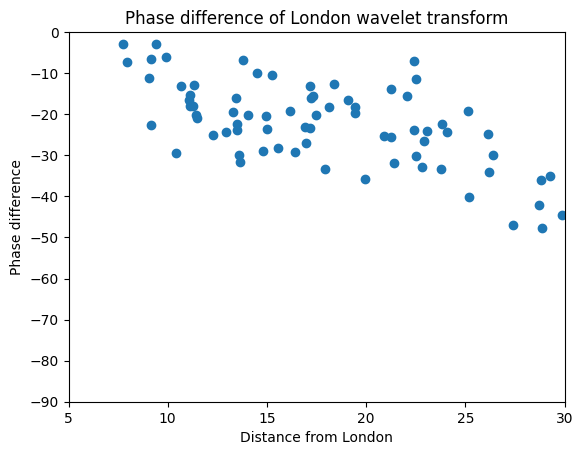

In [17]:
# Get the cases for London from EWdata
distances = np.load(os.path.join("..","..","..", "data", "EnglandWalesdistances.npy"))


EWdata = pd.DataFrame([{"name": placename,
         "population": place.population[0],
         "latitude": place.latitude,
         "longitude": place.longitude} for placename, place in engwal.places.items()])

EWdata["cases"] = EWdata["name"].apply(lambda name: engwal.places[name].cases)

# Calculate distances between all locations
locations = np.array([[place.latitude, place.longitude] for place in engwal.places.values()])

# Calculate wavelet transforms and phase differences from London
london_idx = EWdata[EWdata["name"].str.contains("London", case=False)].index[0]
london_cases = EWdata[EWdata["name"].str.contains("London", case=False)]["cases"].iloc[0]

ref_cwt, frequencies = calc_Ws(np.array(london_cases.flatten()))
distances_from_london = distances[london_idx, :]

x_data, y_data, y2_data = wavelet_phase_diff(  EWdata, distances_from_london, ref_cwt)
# Plot phase differences
plt.plot(x_data, -y_data*180/np.pi, 'o')
plt.xlim(5, 30)
plt.ylim(-90, 0)
plt.xlabel("Distance from London")
plt.ylabel("Phase difference")
plt.title("Phase difference of London wavelet transform")
plt.show()

# NOTE:

**The following cell takes 30-40 minutes to render.**


In [19]:
from tqdm import tqdm

recompute_wavelet = True
if recompute_wavelet:
    results_df["wavelet_y"] = None
    results_df["wavelet_y2"] = None

    for sim_idx in tqdm(range(weekly_incidence.shape[0])):
        cases = weekly_incidence[sim_idx, :, :]
        # Get London cases for this simulation
        london_cases_sim = cases[:, london_idx].flatten()
        ref_cwt_sim, frequencies_sim = calc_Ws(np.array(london_cases_sim[520:]).flatten())
        

        x_sim, y_sim, y2_sim = wavelet_phase_diff(cases[520:, :], distances_from_london, ref_cwt_sim)
        results_df.at[sim_idx, "wavelet_y"] = y_sim
        results_df.at[sim_idx, "wavelet_y2"] = y2_sim
    # Save the DataFrame using pandas to preserve all columns and types
    results_df.to_pickle('outputs/EW_analysis_results.pkl')
else:
    # Load using pandas to get the full DataFrame back
    results_df = pd.read_pickle('outputs/EW_analysis_results.pkl')

 23%|██▎       | 34/150 [07:59<27:09, 14.05s/it]/var/folders/fl/_ns4br_j2qxd92vjrgl3t4n00000gn/T/ipykernel_23939/1269829586.py:21: RuntimeWarning: invalid value encountered in divide
  x = (x - m)/s
100%|██████████| 150/150 [35:17<00:00, 14.11s/it]


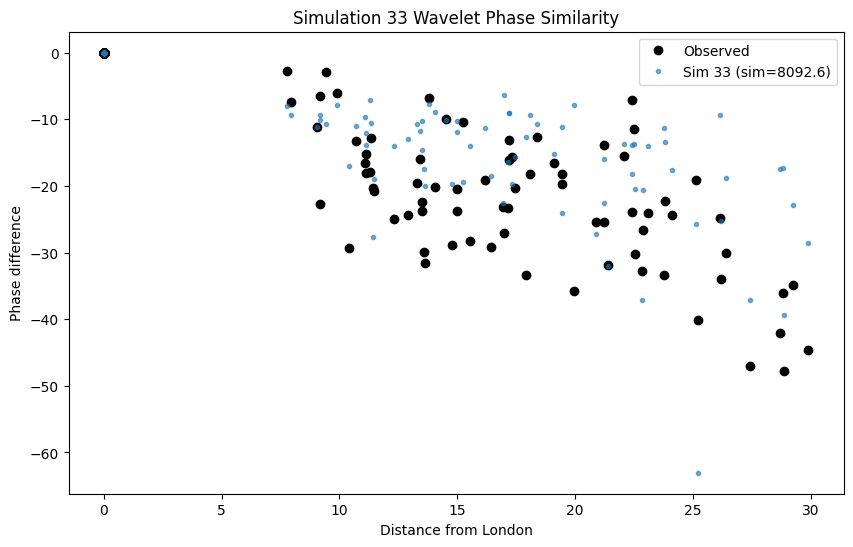

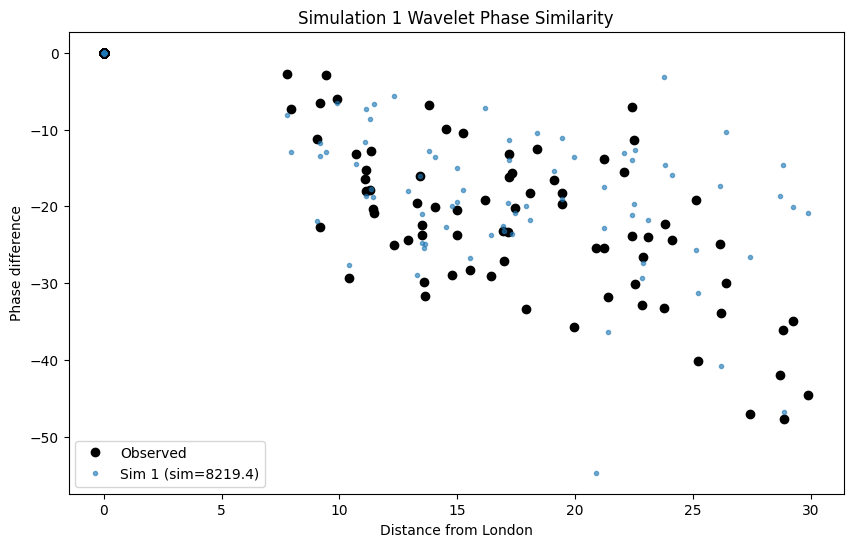

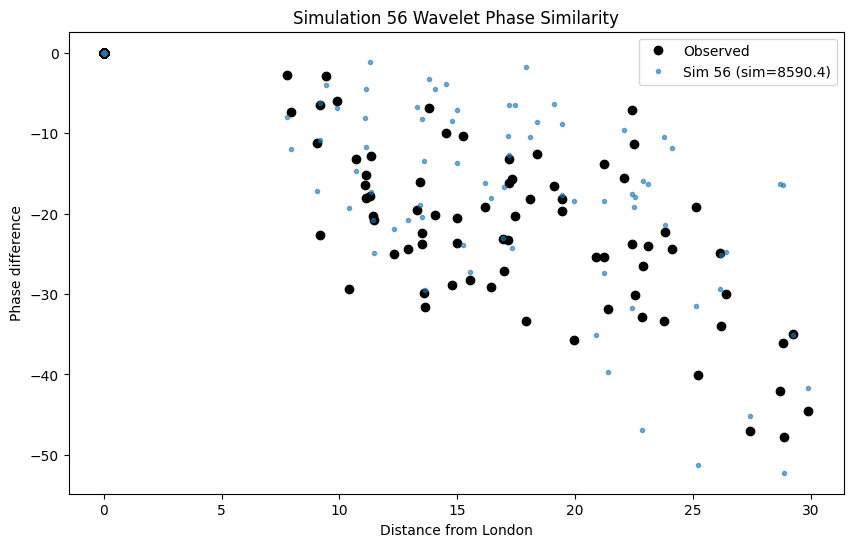

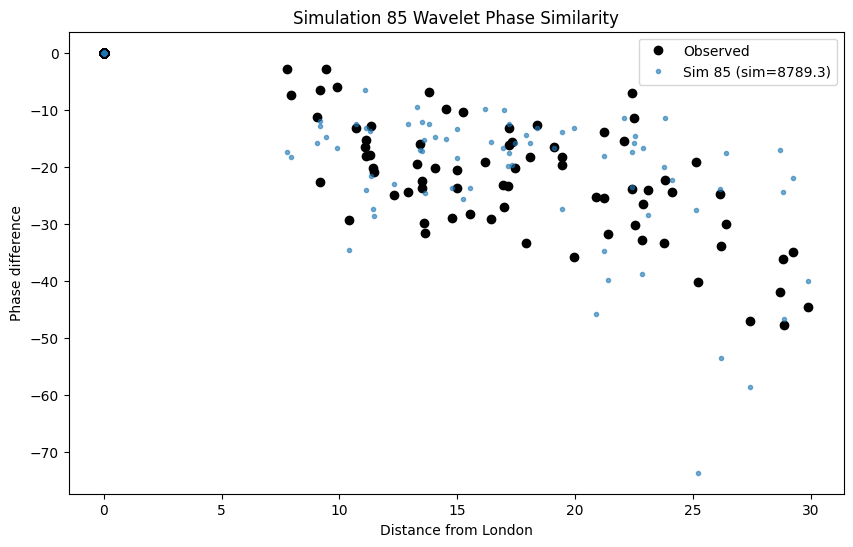

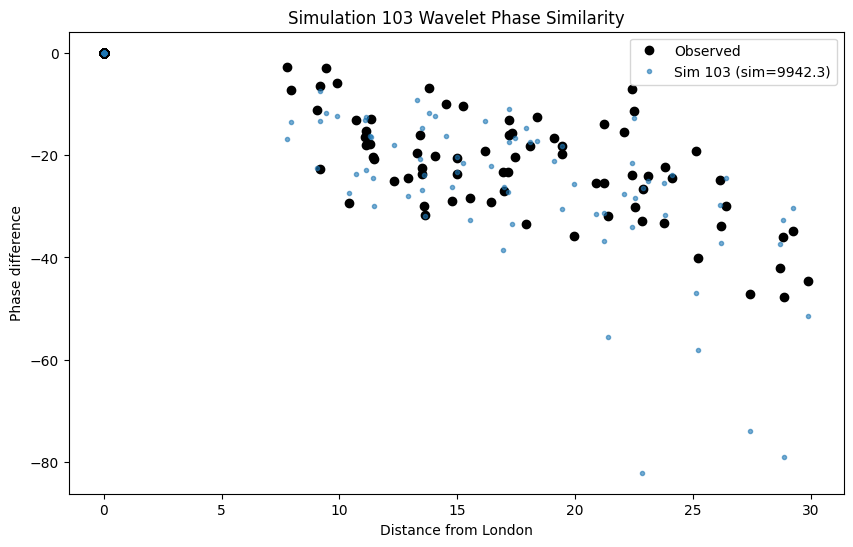

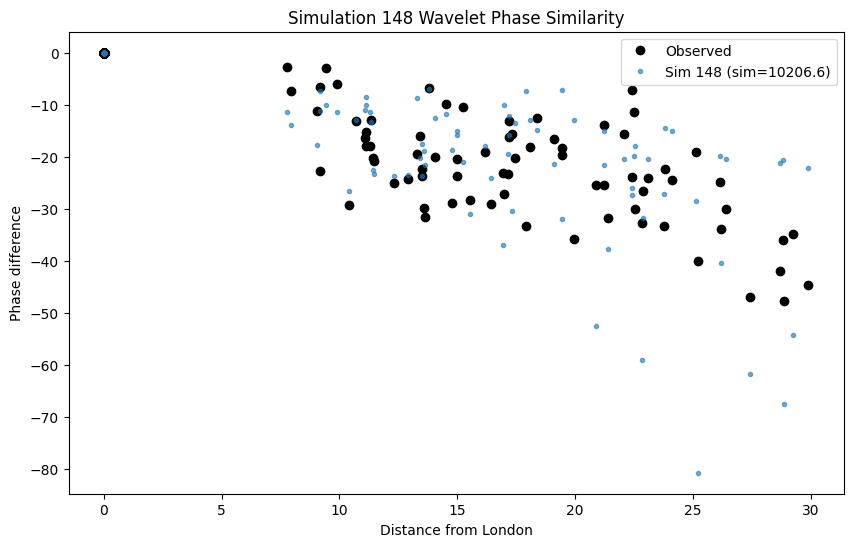

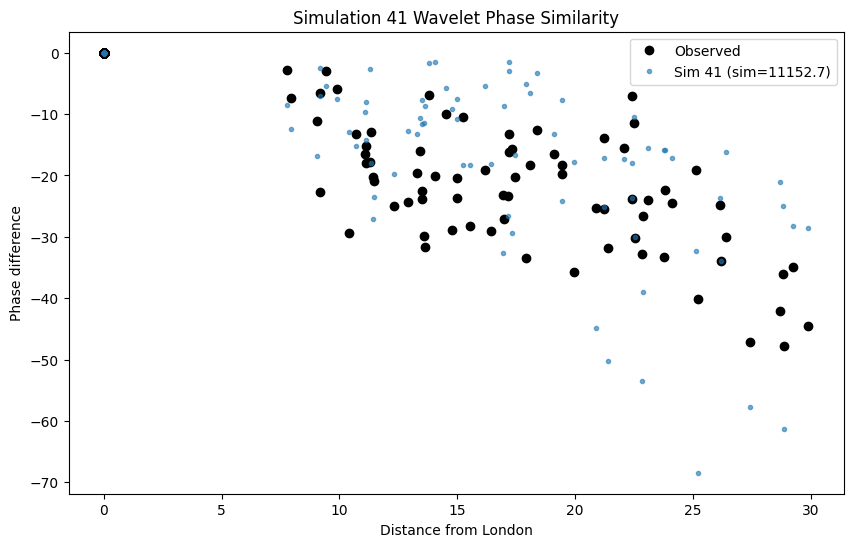

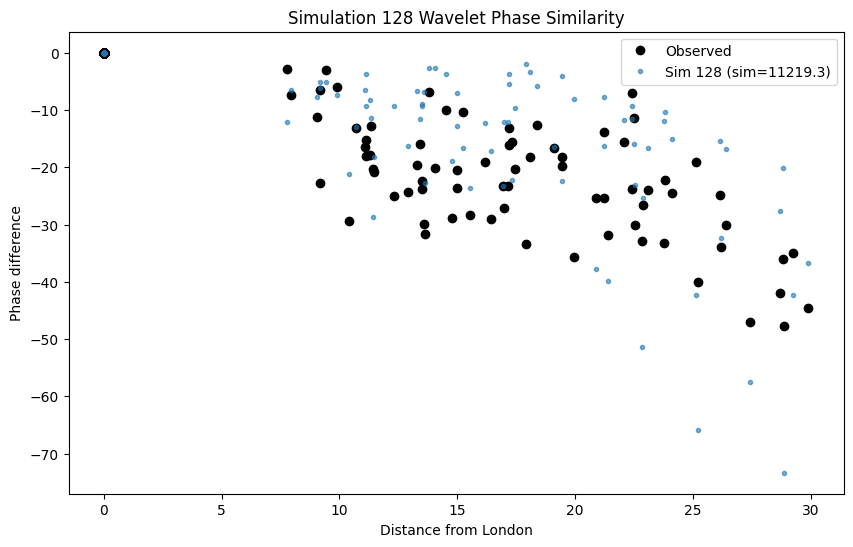

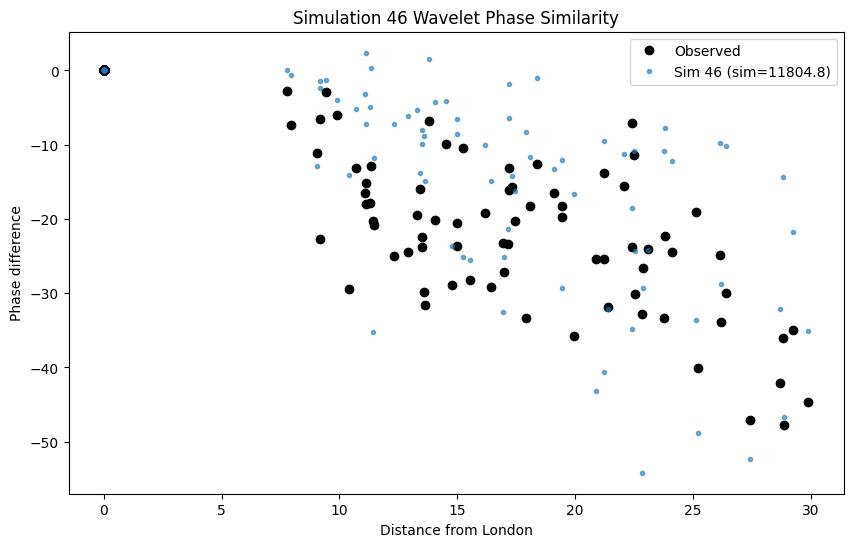

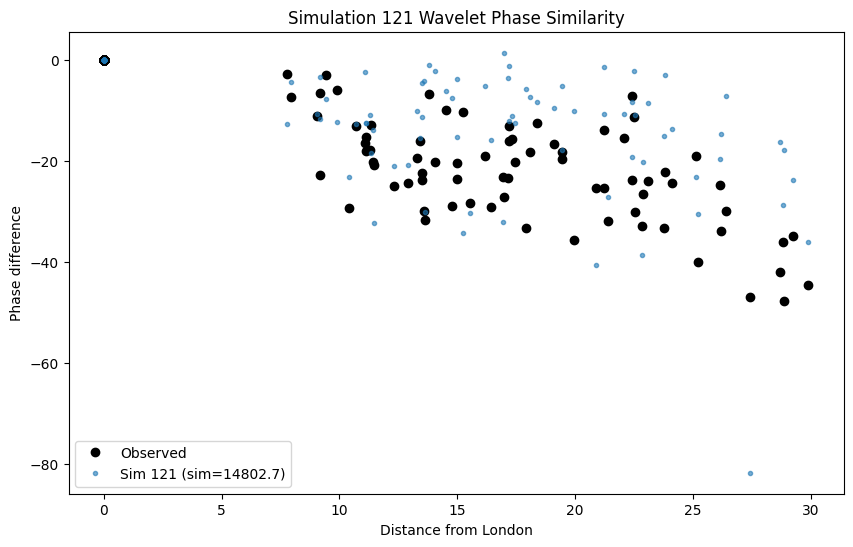

In [20]:
from scipy.stats import linregress

#
mask_data = (x_data > 0) & (y_data != 0)
slope_data, intercept_data, _, _, _ = linregress(x_data[mask_data], -180/np.pi*y_data[mask_data])
# Compute variance of observed phase differences
var_data = np.var(-180/np.pi*y_data[mask_data])

# Define similarity metric as sum of squared differences between observed and simulated phase differences for each city in the mask
def phase_similarity(y_obs, y_sim, mask):
    # Only compare where both masks are valid
    return np.sum(((-180/np.pi)*y_obs[mask] - (-180/np.pi)*y_sim[mask])**2)

sim_phase_diffs = []
for idx, row in results_df.iterrows():
    y_sim = row['wavelet_y']
    if isinstance(y_sim, np.ndarray):
        mask_sim = (x_data > 0) & (y_sim != 0) & (y_data != 0)
        if np.any(mask_sim):
            sim_phase_diffs.append(phase_similarity(y_data, y_sim, mask_sim))
        else:
            sim_phase_diffs.append(np.nan)
    else:
        sim_phase_diffs.append(np.nan)

results_df['wavelet_phase_similarity'] = sim_phase_diffs

# Find the 10 simulations with the lowest phase similarity (best match)
top10_idx = np.argsort(results_df['wavelet_phase_similarity'].values)[:10]

for i, idx in enumerate(top10_idx):
    plt.figure(figsize=(10, 6))
    y_sim = results_df.loc[idx, 'wavelet_y']
    if isinstance(y_sim, np.ndarray):
        plt.plot(x_data, -180/np.pi*y_data, 'ko', label='Observed')
        plt.plot(x_data, -180/np.pi*y_sim, '.', alpha=0.6, label=f'Sim {idx} (sim={results_df.loc[idx, "wavelet_phase_similarity"]:.1f})')
        plt.xlabel('Distance from London')
        plt.ylabel('Phase difference')
        plt.title(f'Simulation {idx} Wavelet Phase Similarity')
        plt.legend()
        plt.show()



Best combined similarity simulation index: 56
Parameters:
beta         3.865332
amplitude    1.310744
k            0.044565
b            0.251464
c            1.563193
Name: 56, dtype: object
CCS similarity rank: 2.0
Wavelet phase similarity rank: 3.0


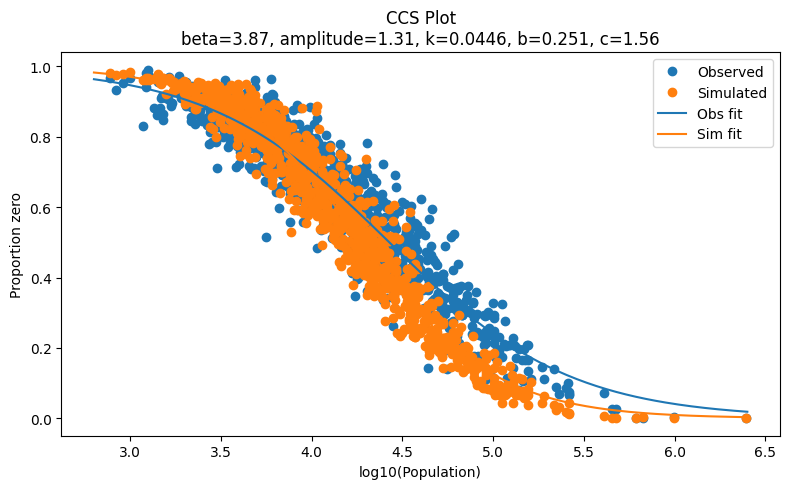

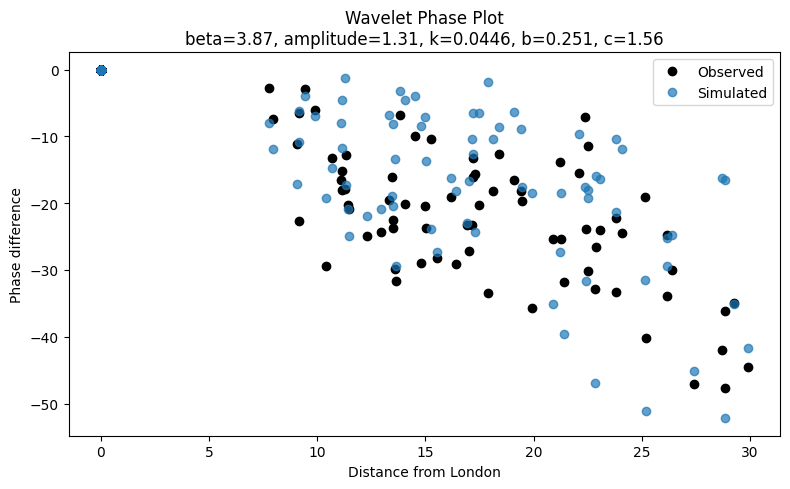

In [21]:
# Rank the simulations by CCS similarity (lower is better)
ccs_ranks = results_df['similarity_CCS'].rank(method='min', ascending=True)
# Rank the simulations by wavelet phase similarity (lower is better)
phase_ranks = results_df['wavelet_phase_similarity'].rank(method='min', ascending=True)

# Combine the ranks (sum of ranks, lower is better)
combined_rank = ccs_ranks + phase_ranks

# Find the index of the simulation with the lowest combined rank
best_idx = combined_rank.idxmin()

print(f"Best combined similarity simulation index: {best_idx}")
print("Parameters:")
print(results_df.loc[best_idx, ['beta', 'amplitude', 'k', 'b', 'c']])
print("CCS similarity rank:", ccs_ranks[best_idx])
print("Wavelet phase similarity rank:", phase_ranks[best_idx])

# Plot CCS (proportion zero vs log10(population))
plt.figure(figsize=(8, 5))
plt.plot(np.log10(model.scenario.population), model.scenario.prop_zero, 'o', label='Observed')
plt.plot(np.log10(model.scenario.population), results_df.loc[best_idx, 'prop_zero'], 'o', label='Simulated')
xfit = np.linspace(2.8, 6.4, 200)
popt_obs = fit_mean_var(np.log10(model.scenario.population), model.scenario.prop_zero)
popt_sim = fit_mean_var(np.log10(model.scenario.population), results_df.loc[best_idx, 'prop_zero'])
plt.plot(xfit, logistic(xfit, *popt_obs), '-', color='C0', label='Obs fit')
plt.plot(xfit, logistic(xfit, *popt_sim), '-', color='C1', label='Sim fit')
plt.xlabel('log10(Population)')
plt.ylabel('Proportion zero')
plt.title('CCS Plot\n' + ', '.join([f'{k}={results_df.loc[best_idx, k]:.3g}' for k in ['beta','amplitude','k','b','c']]))
plt.legend()
plt.tight_layout()
plt.show()

# Plot wavelet phase difference
y_sim = results_df.loc[best_idx, 'wavelet_y']
plt.figure(figsize=(8, 5))
plt.plot(x_data, -180/np.pi*y_data, 'ko', label='Observed')
if isinstance(y_sim, np.ndarray):
    plt.plot(x_data, -180/np.pi*y_sim, 'o', alpha=0.7, label='Simulated')
plt.xlabel('Distance from London')
plt.ylabel('Phase difference')
plt.title('Wavelet Phase Plot\n' + ', '.join([f'{k}={results_df.loc[best_idx, k]:.3g}' for k in ['beta','amplitude','k','b','c']]))
plt.legend()
plt.tight_layout()
plt.show()

### Discussion
A more complete calibration exercise might take these results, and iterate a few more times to fully explore the parameter space that produces good fits to both metrics.  For our purposes, we have demonstrated the model's ability, with a fairly limited number of simulations, to reproduce two of the key spatiotemporal features of the England and Wales dataset, and will stop here.